<a href="https://colab.research.google.com/github/neetosa/Formacao-Machine-Learning-Specialist/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# *Transfer Learning*

-------------------------------
## *What is transfer learning?*
-------------------------------

In transfer learning, the knowledge of an already trained machine learning model is applied to a different but related problem. With transfer learning, we basically try to exploit what has been learned in one task to improve generalization in another. We transfer the weights that a network has learned at “task A” to a new “task B”.

The general idea is to use the knowledge a model has learned from a task with a lot of available labeled training data in a new task that doesn't have much data. Instead of starting the learning process from scratch, we start with patterns learned from solving a related task.

Transfer learning is mostly used in computer vision and natural language processing tasks like sentiment analysis due to the huge amount of computational power required.

-------------------------------
## *How transfer learning works?*
---------------------------------

In computer vision, for example, neural networks usually try to detect edges in the earlier layers, shapes in the middle layer and some task-specific features in the later layers. In transfer learning, the early and middle layers are used and we only retrain the latter layers. It helps leverage the labeled data of the task it was initially trained on.

Let’s go back to the example of a model trained for recognizing a backpack on an image, which will be used to identify sunglasses. In the earlier layers, the model has learned to recognize objects, because of that we will only retrain the latter layers so it will learn what separates sunglasses from other objects.

-------------------------------
## *Why use transfer learning?*
-------------------------------

Transfer learning has several benefits, but the main advantages are saving training time, better performance of neural networks (in most cases), and not needing a lot of data.

-------------------------------
## *When to use transfer learning?*
----------------------------------

As is always the case in machine learning, it is hard to form rules that are generally applicable, but here are some guidelines on when transfer learning might be used:

  - There isn’t enough labeled training data to train your network from scratch;
  - There already exists a network that is pre-trained on a similar task, which is usually trained on massive amounts of data;
  - When task 1 and task 2 have the same input.


In [1]:
# Libraries

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import cv2
import pandas as pd
from google.colab.patches import cv2_imshow
tf.__version__

'2.15.0'

In [2]:
# Connect with the drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Making the extraction of the zip file

path = '/content/drive/MyDrive/cat_dog.zip'
zip_object = zipfile.ZipFile(file = path, mode='r')
zip_object.extractall('./')
zip_object.close()

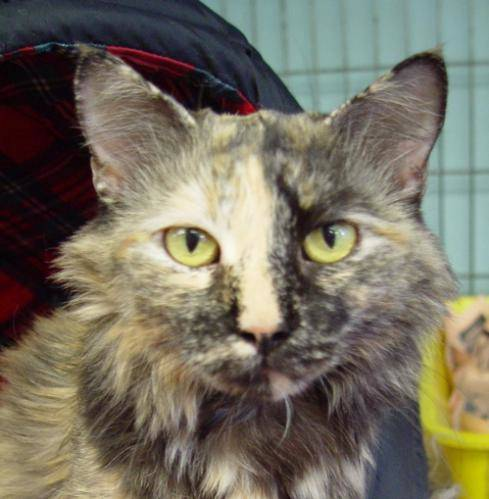

In [5]:
tf.keras.preprocessing.image.load_img('/content/cat_dog/training_set/cat/cat.10.jpg')

In [6]:
# performing resizing and normalization on the training set.

training_generator = ImageDataGenerator(rescale=1./255, rotation_range=7, horizontal_flip=True, zoom_range=0.2)
train_dataset = training_generator.flow_from_directory(
  '/content/cat_dog/training_set',
  target_size = (128, 128),
  batch_size = 128,
  class_mode = 'categorical',
  shuffle = True
  )

Found 4000 images belonging to 2 classes.


Found 4000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


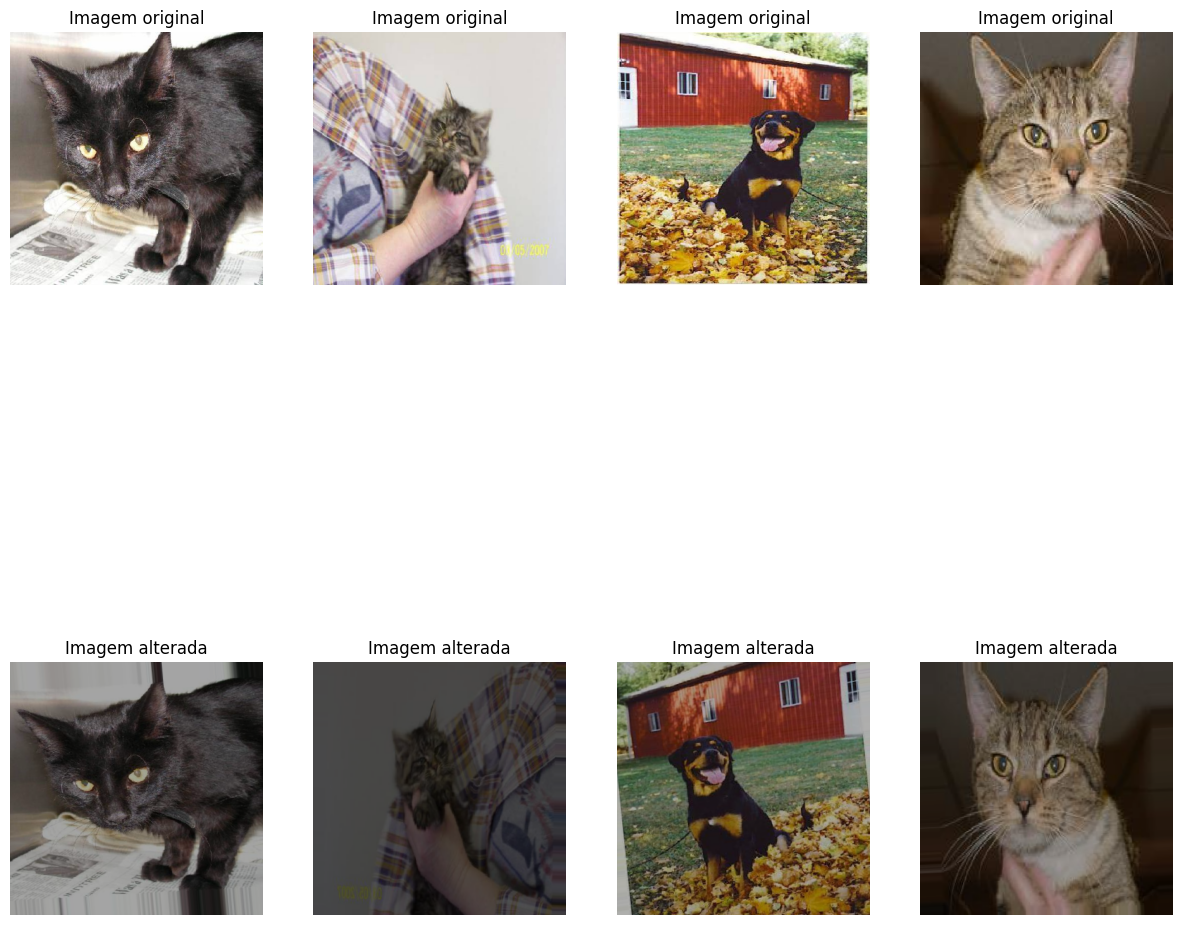

In [7]:
# Changing the images.

datagen = ImageDataGenerator(
  rotation_range = 7,
  zoom_range = 0.2,
  horizontal_flip = True,
  brightness_range=[0.2,1.2]
  )

# Image unchanged.

datanorm = ImageDataGenerator()

# Set with changes

altered_training = datagen.flow_from_directory(
  '/content/cat_dog/training_set',
  target_size=(400, 400),
  color_mode="rgb",
  batch_size=1,
  class_mode="binary",
  seed=2020
  )

# Set without changes

normal_training = datanorm.flow_from_directory(
  '/content/cat_dog/training_set',
  target_size=(400, 400),
  color_mode="rgb",
  batch_size=1,
  class_mode="binary",
  seed=2020
  )

fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15,15))

# Ploting 5 imagens
for i in range(4):

  # convertendo a imagem para inteiro
  image = next(altered_training)[0].astype('uint8')
  image2 = next(normal_training)[0].astype('uint8')

  # alterando o formato (1, 200, 200, 3) para (200, 200, 3) para plotar a imagem
  image = np.squeeze(image)
  image2 = np.squeeze(image2)


  # plotando as imagens
  ax[0,i].imshow(image2)
  ax[0,i].set_title('Imagem original')
  ax[0,i].axis('off')
  ax[1,i].imshow(image)
  ax[1,i].set_title('Imagem alterada')
  ax[1,i].axis('off')

In [8]:
# performing resizing and normalization on the test set.

test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(
  '/content/cat_dog/test_set',
  target_size = (128, 128),
  batch_size = 1,
  class_mode = 'categorical',
  shuffle = False
  )

Found 1000 images belonging to 2 classes.


In [10]:
# Loading the MobileNetV@ model

base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape = (128,128,3))

In [11]:
# Information about the model layers
base_model.summary()

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[

In [12]:
# Viewing the number of model layers

len(base_model.layers)

154

In [13]:
# Freezing layer weights to be reused.

for layer in base_model.layers:
  layer.trainable = False

In [14]:
# Accessing the last layer of the base model, because after it we will add the dense structure.

base_model.output

<KerasTensor: shape=(None, 4, 4, 1280) dtype=float32 (created by layer 'out_relu')>

In [15]:
head_model = base_model.output
head_model = tf.keras.layers.GlobalAveragePooling2D()(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(641, activation = 'relu')(head_model)
head_model = Dropout(0.2)(head_model)
head_model = Dense(2, activation = 'softmax')(head_model)

In [16]:
# Now literally making the connection between the base model and the layers that were implemented.

network = Model(inputs = base_model.input, outputs = head_model)

In [17]:
# viewing layer information.

network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [18]:
# We added the final 6 layers to the model.

len(network.layers)

160

In [19]:
# compiling the model.

network.compile(
  loss = 'categorical_crossentropy',
  optimizer='Adam',
  metrics = ['accuracy'])

In [20]:
# Performing the training with 5 seasons.

historic = network.fit(train_dataset, epochs=5)

Epoch 1/5
32/32 [==============================] - 86s 2s/step - loss: 0.2360 - accuracy: 0.9057
Epoch 2/5
32/32 [==============================] - 115s 4s/step - loss: 0.1061 - accuracy: 0.9595
Epoch 3/5
32/32 [==============================] - 107s 3s/step - loss: 0.0881 - accuracy: 0.9657
Epoch 4/5
32/32 [==============================] - 77s 2s/step - loss: 0.0804 - accuracy: 0.9682
Epoch 5/5
32/32 [==============================] - 106s 3s/step - loss: 0.0735 - accuracy: 0.9697


In [21]:
# Evaluating the neural network with the test set.

network.evaluate(test_dataset)

1000/1000 [==============================] - 23s 21ms/step - loss: 0.1062 - accuracy: 0.9690


[0.10623819380998611, 0.968999981880188]

In [22]:
# Performing predictions on the test set.

predictions = network.predict(test_dataset)
predictions

1000/1000 [==============================] - 25s 24ms/step


array([[7.0090210e-01, 2.9909793e-01],
       [9.9044472e-01, 9.5553324e-03],
       [9.9999869e-01, 1.2519357e-06],
       ...,
       [7.9067685e-02, 9.2093223e-01],
       [2.1911259e-03, 9.9780887e-01],
       [1.0507567e-06, 9.9999893e-01]], dtype=float32)

In [23]:
# Predictions for the test set.

predictions = np.argmax(predictions, axis = 1)
predictions[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
# Actual classification of the test set.

test_dataset.classes[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [25]:
# using sklearn's acuraria function just to compare whether the results are correct.

from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)

0.969

In [26]:
network.evaluate(test_dataset)

1000/1000 [==============================] - 28s 28ms/step - loss: 0.1062 - accuracy: 0.9690


[0.10623819380998611, 0.968999981880188]

In [27]:
train_dataset.class_indices

{'cat': 0, 'dog': 1}

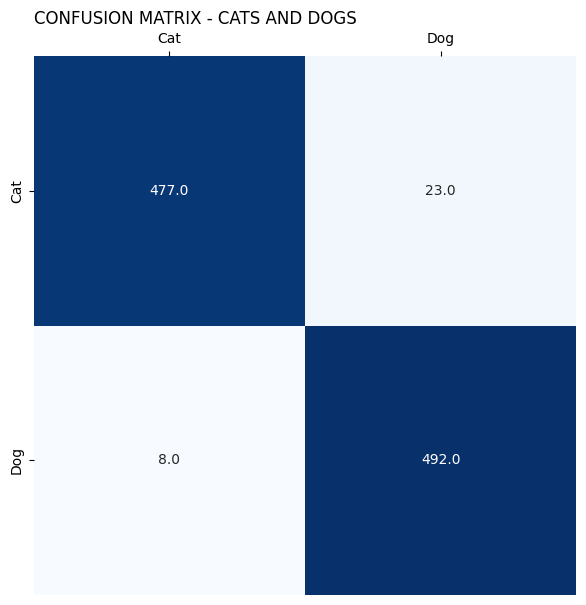

In [28]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
# figure
fig, ax = plt.subplots(figsize=(7, 7))
# plot heatmap
sns.heatmap(cm, cmap="Blues",annot=True,fmt=".1f",cbar=False)
# xticks
ax.xaxis.tick_top()
xticks_labels = ['Cat', 'Dog']
plt.xticks(np.arange(2) + .5, labels=xticks_labels)

# yticks
ax.yaxis.tick_left()
yticks_labels = ['Cat', 'Dog']
plt.yticks(np.arange(2) + .5, labels=yticks_labels)
# axis labels
plt.xlabel('')
plt.ylabel('')
# title
title = 'Confusion matrix - Cats and Dogs'.upper()
plt.title(title, loc='left')
plt.show()

In [29]:
from sklearn.metrics import classification_report

print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       500
           1       0.96      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [30]:
# Saving model parameters.

model_json = network.to_json()
with open('network.json','w') as json_file:
  json_file.write(model_json)

In [31]:
# Saving layer weights.

from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

<ipython-input-31-6a934c211ab0>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  network_saved = save_model(network, '/content/weights.hdf5')


In [32]:
# viewing the.json file.

with open('network.json', 'r') as json_file:
  json_saved_model = json_file.read()
json_saved_model

'{"class_name": "Functional", "config": {"name": "model", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 128, 128, 3], "dtype": "float32", "sparse": false, "ragged": false, "name": "input_2"}, "registered_name": null, "name": "input_2", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "Conv2D", "config": {"name": "Conv1", "trainable": false, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [2, 2], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "groups": 1, "activation": "linear", "use_bias": false, "kernel_initializer": {"module": "keras.initializers", "class_name": "GlorotUniform", "config": {"seed": null}, "registered_name": null}, "bias_initializer": {"module": "keras.initializers", "class_name": "Zeros", "config": {}, "registered_name": null}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint

In [33]:
# Loading the saved model

network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(loss = 'categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [34]:
# checking layer information.

network_loaded.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

In [40]:
# loading an image

image = cv2.imread('/content/cat_dog/test_set/dog/dog.3501.jpg')

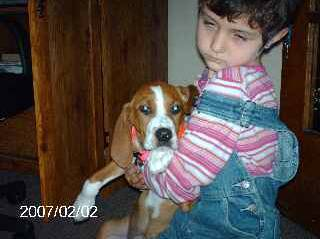

In [41]:
cv2_imshow(image)

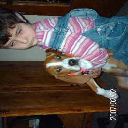

In [43]:
# Changing to the default size and rotating the image to make classification difficult.

image = cv2.resize(image, (128, 128))
image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2_imshow(image)

In [44]:
# Normalizing the image.

image = image / 255
image

array([[[0.03921569, 0.07843137, 0.10588235],
        [0.04705882, 0.08627451, 0.11372549],
        [0.06666667, 0.09803922, 0.1254902 ],
        ...,
        [0.05098039, 0.03921569, 0.07843137],
        [0.05490196, 0.03921569, 0.06666667],
        [0.0627451 , 0.04705882, 0.07058824]],

       [[0.02352941, 0.07058824, 0.09803922],
        [0.02352941, 0.0627451 , 0.09019608],
        [0.01568627, 0.04705882, 0.0745098 ],
        ...,
        [0.02745098, 0.01960784, 0.05490196],
        [0.07843137, 0.0627451 , 0.08627451],
        [0.12941176, 0.11372549, 0.12941176]],

       [[0.1254902 , 0.18039216, 0.21960784],
        [0.12156863, 0.17647059, 0.21176471],
        [0.14901961, 0.19215686, 0.23137255],
        ...,
        [0.0627451 , 0.0627451 , 0.08235294],
        [0.11372549, 0.10588235, 0.11372549],
        [0.14901961, 0.1372549 , 0.14117647]],

       ...,

       [[0.16078431, 0.14901961, 0.09411765],
        [0.14901961, 0.14509804, 0.09411765],
        [0.07058824, 0

In [45]:
# Checking the format

image.shape

(128, 128, 3)

In [46]:
# It is necessary to perform the reshape so that the model understands the format.

image = image.reshape(1,128,128,3)

In [47]:
# Carrying out the prediction.

prediction = network_loaded(image)
prediction

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.02020273, 0.9797973 ]], dtype=float32)>

In [49]:
prediction = np.argmax(prediction)
prediction

1

In [50]:
test_dataset.class_indices

{'cat': 0, 'dog': 1}

In [51]:
if prediction == 0:
  print('The model identified that the animal as: Cat')
else:
  print('The model identified that the animal as: Dog')

The model identified that the animal as: Dog
